# Tutorial:RNA+ADT (well-labeled)

In this tutorial, we will show how to cluster RNA+ADT(well-labeled) data using scMAGCA. As an example, we use a paired human peripheral blood sample dataset '10X1kpbmc' containing 713 cells with two omics. Among them, ADT has 17 features, while RNA contains 33,538 features.

## Loading package

In [4]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import random
import warnings
warnings.filterwarnings("ignore")

In [5]:
from scMAGCA.preprocess import read_dataset, preprocess_dataset
from scMAGCA.utils import *
from scMAGCA.scMAGCA import scMultiCluster

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

## Reading dataset

The required input files include: 
1) x1: protein abundance matrix (data format is h5ad file) : 10X1kpbmc_adt.h5ad; \
2) x2: Gene expression matrix (data format is h5ad file) : 10X1kpbmc_rna.h5ad; \
3) Real label (stored as csv file) : 10X1kpbmc_label.csv.

To ensure reproducibility of the results, please read the above data as follows:

In [7]:
x1 = np.array(sc.read_h5ad('../datasets/10X1kpbmc/10X1kpbmc_adt.h5ad').to_df()).astype('float32')
x2 = np.array(sc.read_h5ad('../datasets/10X1kpbmc/10X1kpbmc_rna.h5ad').to_df()).astype('float32')
y = np.array(pd.read_csv('../datasets/10X1kpbmc/10X1kpbmc_label.csv')['Cluster']).astype('float32')

In [8]:
x1,x2,y

(array([[3.000e+00, 6.000e+00, 2.000e+00, ..., 3.000e+00, 4.000e+00,
         1.000e+00],
        [3.444e+03, 3.995e+03, 4.900e+01, ..., 6.000e+00, 8.000e+00,
         2.000e+00],
        [1.733e+03, 3.401e+03, 2.300e+01, ..., 1.000e+00, 6.000e+00,
         0.000e+00],
        ...,
        [3.000e+00, 1.190e+02, 1.800e+01, ..., 1.000e+00, 1.000e+00,
         2.000e+00],
        [1.700e+01, 8.190e+02, 1.100e+01, ..., 3.000e+00, 2.000e+00,
         2.000e+00],
        [9.000e+00, 1.300e+01, 1.000e+01, ..., 4.000e+00, 1.100e+01,
         5.000e+00]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5., 1., 1., 1., 1., 3., 3., 3., 1., 1., 3., 1., 1., 1., 5., 3., 3.,
        3., 3., 2., 3., 1., 2., 1., 3., 4., 2., 5., 1., 1., 2., 5., 1., 4.,
        2., 1.

Due to the small number of features in ADT omics data and the large gap between the feature dimensions of RNA omics, for RNA+ADT data, we only select high-expression features for RNA omics (the default number of chosen genes is 2000).

Chosen offset: 0.21


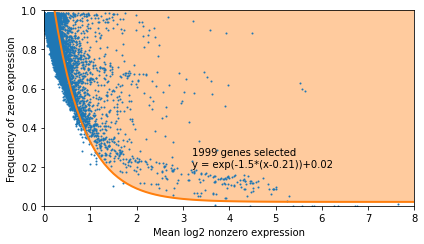

In [11]:
importantGenes = geneSelection(x2, n=2000)
x2 = x2[:, importantGenes]

In [12]:
adata1 = sc.AnnData(x1)
adata1 = read_dataset(adata1, copy=True)
adata1 = preprocess_dataset(adata1, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 17 features and 713 cells.


In [13]:
adata1

AnnData object with n_obs × n_vars = 713 × 17
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

In [14]:
adata2 = sc.AnnData(x2)
adata2 = read_dataset(adata2, copy=True)
adata2 = preprocess_dataset(adata2, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 1999 features and 713 cells.


In [15]:
adata2

AnnData object with n_obs × n_vars = 713 × 1999
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

## Training the model

Our model training is divided into two stages: pre-training stage and formal training stage. The number of epochs in the pre-training phase is set to 400, while the number in the formal training is 2000. In formal training, if the change in training results reaches a set threshold, it will end early. <br>

After the training, the potential representations and predicted label values obtained by scMAGCA are saved to the corresponding folder of the data set and can be used for subsequent downstream analysis.

In [16]:
model = scMultiCluster(input_dim1=adata1.n_vars,input_dim2=adata2.n_vars,
                       alpha=0.5,beta=1,gama=0.1,device='cuda').to('cuda')

In [17]:
model

scMultiCluster(
  (encoder): Encoder(
    (stacked_gnn): ModuleList(
      (0): GCNConv(2016, 1024)
      (1): GCNConv(1024, 256)
      (2): GCNConv(256, 64)
      (3): GCNConv(64, 32)
    )
    (stacked_bns): ModuleList(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (3): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
    (stacked_prelus): ModuleList(
      (0-3): 4 x PReLU(num_parameters=1)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, moment

In [18]:
pretrain_latent = model.pretrain_autoencoder(
                        X1=adata1.X, X2=adata2.X, X1_raw=adata1.raw.X, X2_raw=adata2.raw.X, 
                        epochs=400, file='10X1kpbmc')

Pretraining stage
Pretrain epoch 1, recon_loss:1.179670, zinb_loss:3.310244, adversial_loss:1.358601
Pretrain epoch 2, recon_loss:1.053315, zinb_loss:2.773893, adversial_loss:1.373735
Pretrain epoch 3, recon_loss:0.862565, zinb_loss:2.396230, adversial_loss:1.360926
Pretrain epoch 4, recon_loss:0.777968, zinb_loss:2.083947, adversial_loss:1.360451
Pretrain epoch 5, recon_loss:0.754381, zinb_loss:1.846060, adversial_loss:1.360216
Pretrain epoch 6, recon_loss:0.733581, zinb_loss:1.646314, adversial_loss:1.355564
Pretrain epoch 7, recon_loss:0.721840, zinb_loss:1.484166, adversial_loss:1.350406
Pretrain epoch 8, recon_loss:0.717826, zinb_loss:1.361452, adversial_loss:1.347699
Pretrain epoch 9, recon_loss:0.708908, zinb_loss:1.277065, adversial_loss:1.346102
Pretrain epoch 10, recon_loss:0.694630, zinb_loss:1.224692, adversial_loss:1.344238
Pretrain epoch 11, recon_loss:0.684225, zinb_loss:1.194159, adversial_loss:1.342163
Pretrain epoch 12, recon_loss:0.680018, zinb_loss:1.175642, adversi

Pretrain epoch 99, recon_loss:0.600360, zinb_loss:0.950071, adversial_loss:1.271988
Pretrain epoch 100, recon_loss:0.597603, zinb_loss:0.946913, adversial_loss:1.272954
Pretrain epoch 101, recon_loss:0.598265, zinb_loss:0.948654, adversial_loss:1.273010
Pretrain epoch 102, recon_loss:0.598125, zinb_loss:0.946708, adversial_loss:1.272140
Pretrain epoch 103, recon_loss:0.596699, zinb_loss:0.946644, adversial_loss:1.271546
Pretrain epoch 104, recon_loss:0.596948, zinb_loss:0.945447, adversial_loss:1.271937
Pretrain epoch 105, recon_loss:0.594884, zinb_loss:0.945366, adversial_loss:1.271829
Pretrain epoch 106, recon_loss:0.595728, zinb_loss:0.944949, adversial_loss:1.270860
Pretrain epoch 107, recon_loss:0.593774, zinb_loss:0.944627, adversial_loss:1.270213
Pretrain epoch 108, recon_loss:0.593907, zinb_loss:0.944016, adversial_loss:1.270924
Pretrain epoch 109, recon_loss:0.592436, zinb_loss:0.943547, adversial_loss:1.270654
Pretrain epoch 110, recon_loss:0.593074, zinb_loss:0.943505, adver

Pretrain epoch 196, recon_loss:0.553550, zinb_loss:0.929222, adversial_loss:1.257241
Pretrain epoch 197, recon_loss:0.550400, zinb_loss:0.928963, adversial_loss:1.256553
Pretrain epoch 198, recon_loss:0.550799, zinb_loss:0.929040, adversial_loss:1.256077
Pretrain epoch 199, recon_loss:0.550205, zinb_loss:0.928932, adversial_loss:1.256700
Pretrain epoch 200, recon_loss:0.548488, zinb_loss:0.928861, adversial_loss:1.256489
Pretrain epoch 201, recon_loss:0.549529, zinb_loss:0.929483, adversial_loss:1.255842
Pretrain epoch 202, recon_loss:0.552430, zinb_loss:0.930490, adversial_loss:1.255978
Pretrain epoch 203, recon_loss:0.555417, zinb_loss:0.932157, adversial_loss:1.256537
Pretrain epoch 204, recon_loss:0.552969, zinb_loss:0.932155, adversial_loss:1.255958
Pretrain epoch 205, recon_loss:0.548828, zinb_loss:0.928827, adversial_loss:1.255473
Pretrain epoch 206, recon_loss:0.547778, zinb_loss:0.928655, adversial_loss:1.255564
Pretrain epoch 207, recon_loss:0.549267, zinb_loss:0.929921, adve

Pretrain epoch 293, recon_loss:0.500745, zinb_loss:0.921814, adversial_loss:1.248916
Pretrain epoch 294, recon_loss:0.501947, zinb_loss:0.922106, adversial_loss:1.248188
Pretrain epoch 295, recon_loss:0.498946, zinb_loss:0.921893, adversial_loss:1.248592
Pretrain epoch 296, recon_loss:0.496131, zinb_loss:0.921547, adversial_loss:1.248443
Pretrain epoch 297, recon_loss:0.496319, zinb_loss:0.921698, adversial_loss:1.248167
Pretrain epoch 298, recon_loss:0.496336, zinb_loss:0.921654, adversial_loss:1.248361
Pretrain epoch 299, recon_loss:0.496867, zinb_loss:0.921532, adversial_loss:1.248230
Pretrain epoch 300, recon_loss:0.495937, zinb_loss:0.921501, adversial_loss:1.248012
Pretrain epoch 301, recon_loss:0.498234, zinb_loss:0.922171, adversial_loss:1.248614
Pretrain epoch 302, recon_loss:0.503863, zinb_loss:0.923424, adversial_loss:1.247572
Pretrain epoch 303, recon_loss:0.495321, zinb_loss:0.922800, adversial_loss:1.248073
Pretrain epoch 304, recon_loss:0.498044, zinb_loss:0.921611, adve

Pretrain epoch 391, recon_loss:0.441706, zinb_loss:0.916533, adversial_loss:1.244172
Pretrain epoch 392, recon_loss:0.437726, zinb_loss:0.916482, adversial_loss:1.243456
Pretrain epoch 393, recon_loss:0.427984, zinb_loss:0.916146, adversial_loss:1.243696
Pretrain epoch 394, recon_loss:0.428263, zinb_loss:0.916296, adversial_loss:1.243844
Pretrain epoch 395, recon_loss:0.431406, zinb_loss:0.916571, adversial_loss:1.243382
Pretrain epoch 396, recon_loss:0.424839, zinb_loss:0.916067, adversial_loss:1.243597
Pretrain epoch 397, recon_loss:0.426324, zinb_loss:0.916186, adversial_loss:1.243752
Pretrain epoch 398, recon_loss:0.432253, zinb_loss:0.916296, adversial_loss:1.243196
Pretrain epoch 399, recon_loss:0.433320, zinb_loss:0.916364, adversial_loss:1.243449
Pretrain epoch 400, recon_loss:0.431458, zinb_loss:0.916175, adversial_loss:1.243666


In [19]:
y_pred, final_latent = model.fit(y=y, n_clusters=5, file='10X1kpbmc')

Clustering stage
Initializing cluster centers with kmeans.
Initializing k-means: AMI= 0.8205, NMI= 0.8218, ARI= 0.8344, ACC= 0.9201
Training epoch 1, recon_loss:0.430522, zinb_loss:0.916023, cluster_loss:0.154342
Clustering   1: AMI= 0.8205, NMI= 0.8218, ARI= 0.8344, ACC= 0.9201
0.0
Training epoch 2, recon_loss:0.846306, zinb_loss:1.077583, cluster_loss:0.171737
Clustering   2: AMI= 0.8006, NMI= 0.8021, ARI= 0.8141, ACC= 0.9088
0.014025245441795231
Training epoch 3, recon_loss:0.778181, zinb_loss:1.139828, cluster_loss:0.164231
Clustering   3: AMI= 0.8304, NMI= 0.8316, ARI= 0.8507, ACC= 0.9341
0.03225806451612903
Training epoch 4, recon_loss:0.784476, zinb_loss:1.364775, cluster_loss:0.169950
Clustering   4: AMI= 0.8110, NMI= 0.8124, ARI= 0.8221, ACC= 0.9159
0.03927068723702665
Training epoch 5, recon_loss:0.830803, zinb_loss:1.707875, cluster_loss:0.176492
Clustering   5: AMI= 0.8033, NMI= 0.8047, ARI= 0.7921, ACC= 0.8780
0.06591865357643759
Training epoch 6, recon_loss:0.802670, zinb

Training epoch 49, recon_loss:0.577148, zinb_loss:0.950773, cluster_loss:0.141801
Clustering   49: AMI= 0.8182, NMI= 0.8195, ARI= 0.8240, ACC= 0.9130
0.015427769985974754
Training epoch 50, recon_loss:0.582462, zinb_loss:0.950802, cluster_loss:0.140044
Clustering   50: AMI= 0.8189, NMI= 0.8202, ARI= 0.8294, ACC= 0.9186
0.011220196353436185
Training epoch 51, recon_loss:0.578021, zinb_loss:0.947385, cluster_loss:0.141623
Clustering   51: AMI= 0.8176, NMI= 0.8190, ARI= 0.8274, ACC= 0.9173
0.001402524544179523
Training epoch 52, recon_loss:0.593130, zinb_loss:0.945707, cluster_loss:0.141130
Clustering   52: AMI= 0.8155, NMI= 0.8169, ARI= 0.8199, ACC= 0.9116
0.008415147265077139
Training epoch 53, recon_loss:0.584805, zinb_loss:0.945096, cluster_loss:0.142527
Clustering   53: AMI= 0.8202, NMI= 0.8215, ARI= 0.8314, ACC= 0.9201
0.011220196353436185
Training epoch 54, recon_loss:0.585467, zinb_loss:0.943358, cluster_loss:0.140558
Clustering   54: AMI= 0.8144, NMI= 0.8158, ARI= 0.8180, ACC= 0.

In [ ]:
import numpy as np

y_pred_ = best_map(y, y_pred).astype(int)
np.savetxt("../results/10X1kpbmc_pred.csv", y_pred, delimiter=",")
np.savetxt("../results/10X1kpbmc_embedding.csv", final_latent.cpu().detach().numpy(), delimiter=",")

In [41]:
library(umap)
library(ggplot2)
library(scattermore)

In [42]:
latent <- read.csv(file = "../results/10X1kpbmc_embedding.csv", sep = ",", header = FALSE)
y_pred <- read.csv(file = "../results/10X1kpbmc_pred.csv", sep = ",", header = FALSE)

In [43]:
z.umap<-umap(latent)
y_pred$V1<-as.factor(y_pred$V1)

In [44]:
bm_table_num <- data.frame(UMAP1=z.umap$layout[,1], UMAP2=z.umap$layout[,2],Cluster = y_pred$V1)
bm_plot1 <- ggplot(bm_table_num, aes(x = UMAP1, y = UMAP2, color = Cluster)) +
  geom_point(size = 0.1) +
  ggtitle('scMAGCA') +
  theme_bw(base_line_size = 1,base_rect_size = 1)+
  scale_color_manual(values = c("1"="#e0bc58", "2"="#64abc0", "3"="#dc8e97", "4"="#74a893", "5"="#ac9141"))+
  labs(x = "", y = "", color = "Label")+  # Set x and y axis labels
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, face = 'bold'),  # Set title to center
    panel.border = element_blank(),
    axis.ticks.length=unit(0, "lines"),  # Remove axis ticks but keep axis labels
    axis.text = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = NA),
    axis.title.x = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    axis.title.y = element_text(size = 15, hjust = 0.5, vjust = 0.5, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 15),
    legend.position = "none")+
  guides(color = guide_legend(override.aes = list(size = 5), nrow=2))

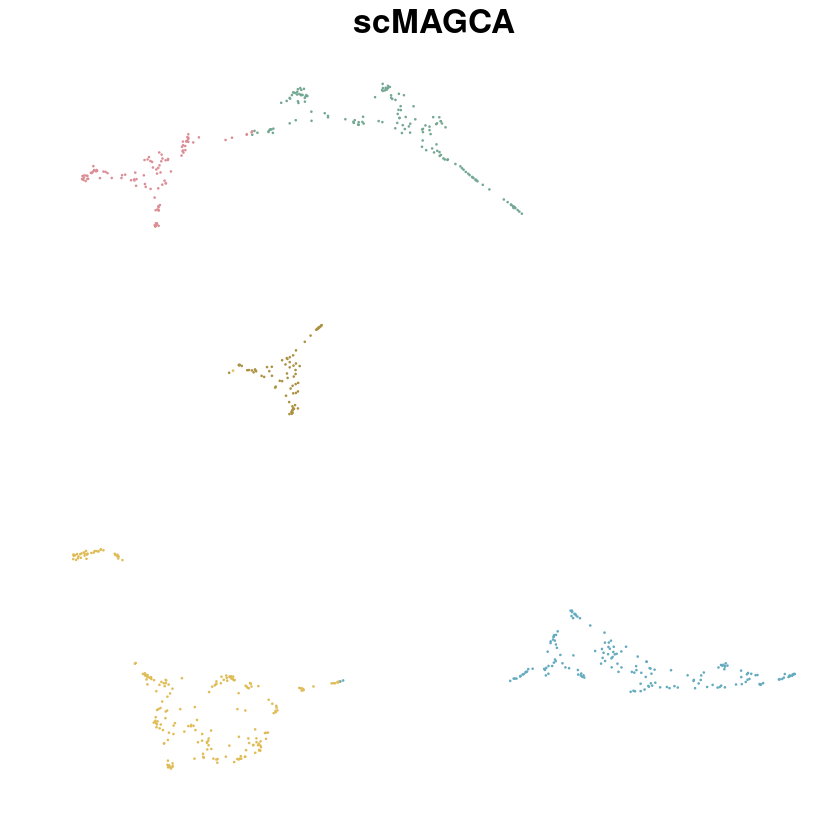

In [45]:
bm_plot1